In [85]:
import pandas as pd 
import numpy as np 
import pickle 
from sklearn.metrics import accuracy_score 
from pdpbox import pdp, info_plots 
from matplotlib import pyplot as plt 
from pycebox.ice import ice, ice_plot 
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import plot_partial_dependence

In [86]:
## Load the sigmoid model 
model = pickle.load(open('rbf_model.sav', 'rb')) 

## Load in the data 
## Read in csv 
df = pd.read_csv('model_data.csv', 
                                index_col = ['year', 'ID']).dropna()

## Test and train split for time series
train = df.head(
    int(df.shape[0] * 0.8 ) 
) 

test = df.tail(
    int(df.shape[0] * 0.2) 
)

## Split into x and y 
def SplitData(df): 
    y = df.lead_rating 
    x = df.drop('lead_rating', axis = 1) 
    
    return x, y 

train_x, train_y = SplitData(train) 
test_x, test_y = SplitData(test) 

## Look at the initial model accuracy 
print(
    accuracy_score(model.predict(test_x), test_y) 
)
print(df.shape) 
cols = df.columns.tolist()
print(cols) 
cols[1]

0.6933701657458563
(1813, 13)
['lead_rating', 'rating', 'IQ_TOTAL_ASSETS', 'IQ_TOTAL_REV', 'IQ_NI_CF', 'IQ_AR', 'IQ_GP ', 'IQ_AP', 'IQ_TOTAL_LIAB', 'IQ_TOTAL_DEBT', 'IQ_CASH_FINAN', 'IQ_TOTAL_EQUITY', 'IQ_CASH_EQUIV']


'rating'

We can see there are 13 columns 

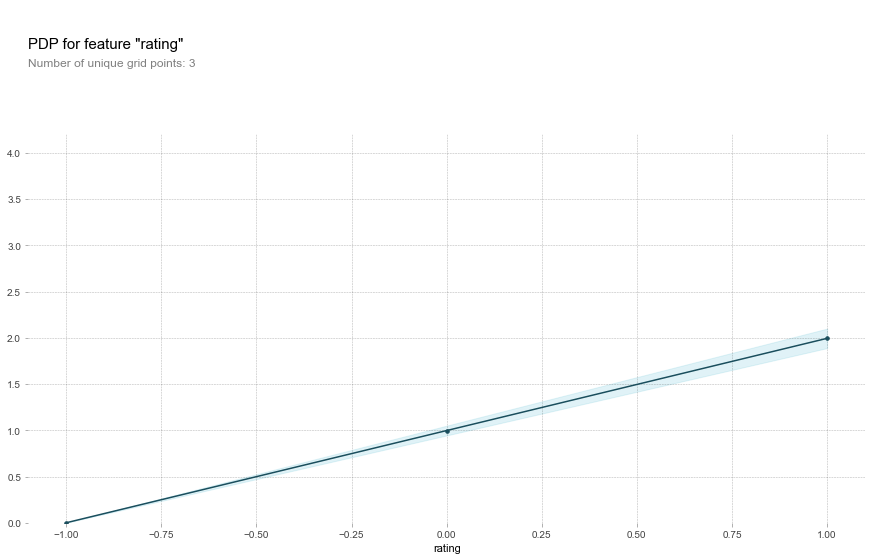

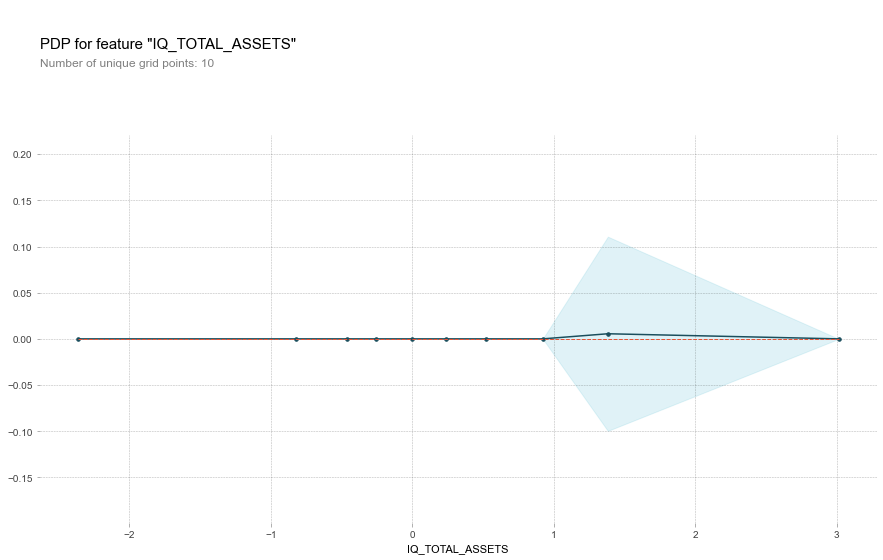

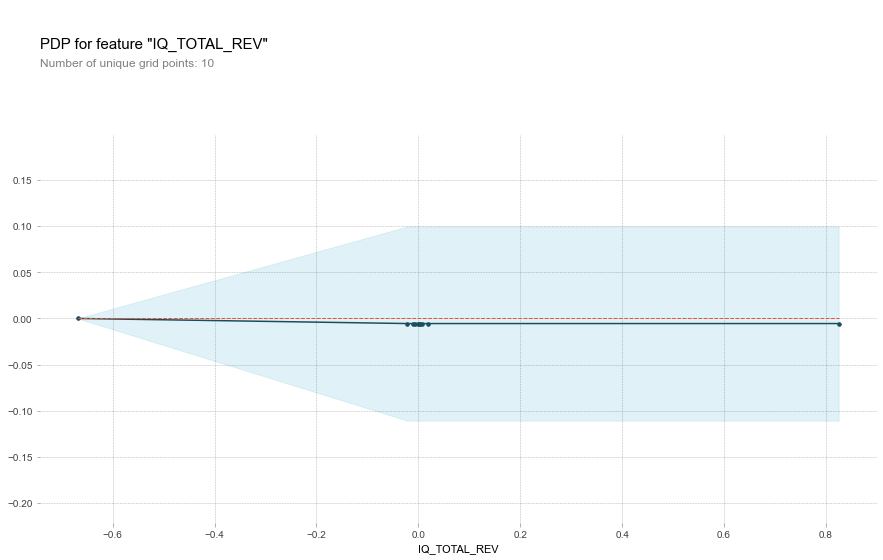

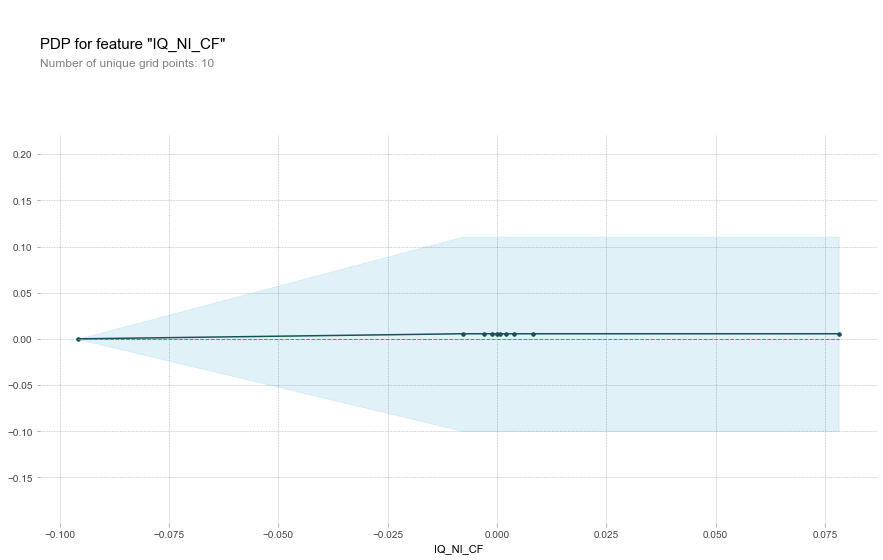

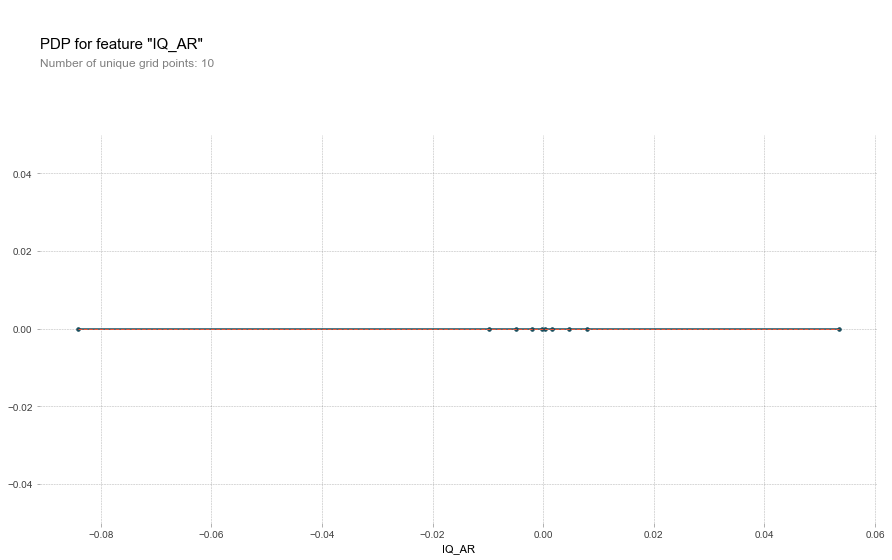

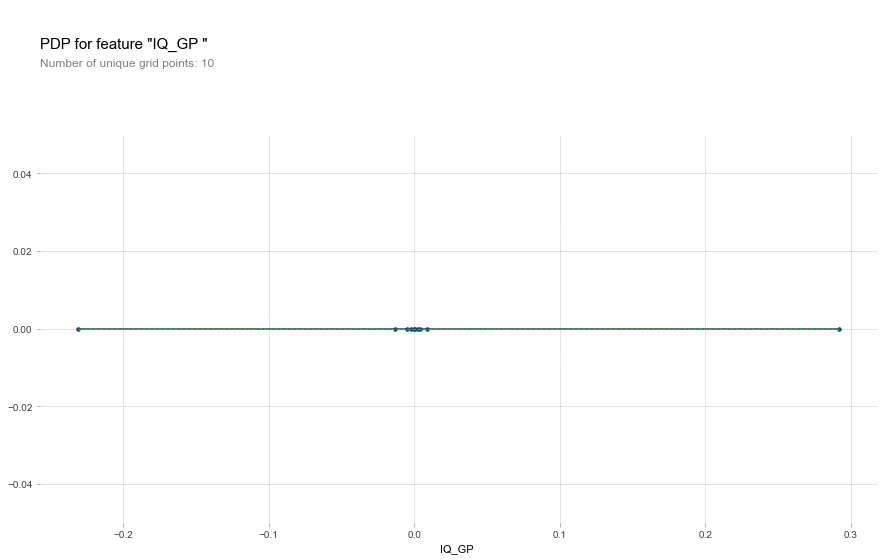

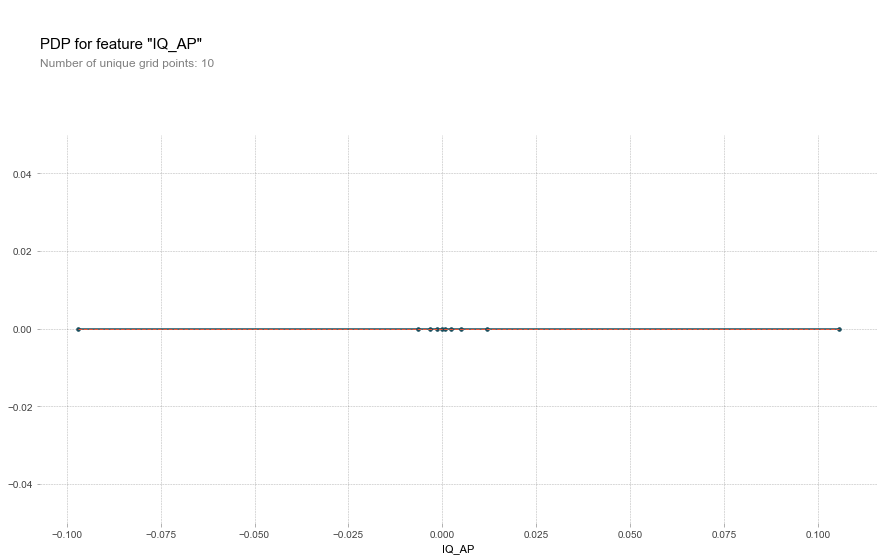

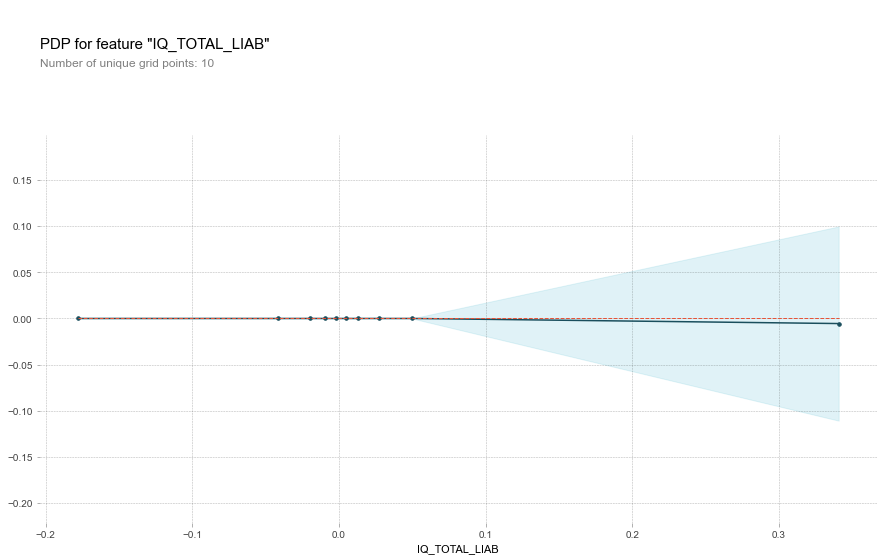

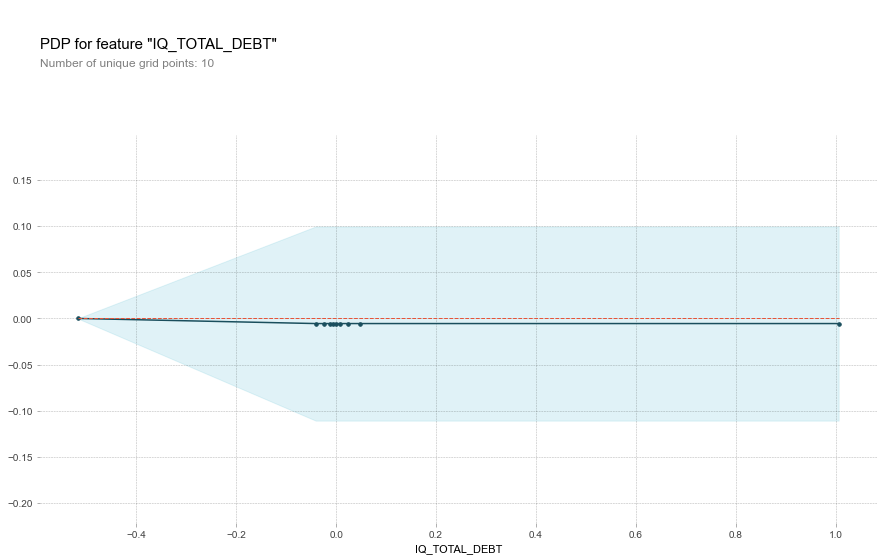

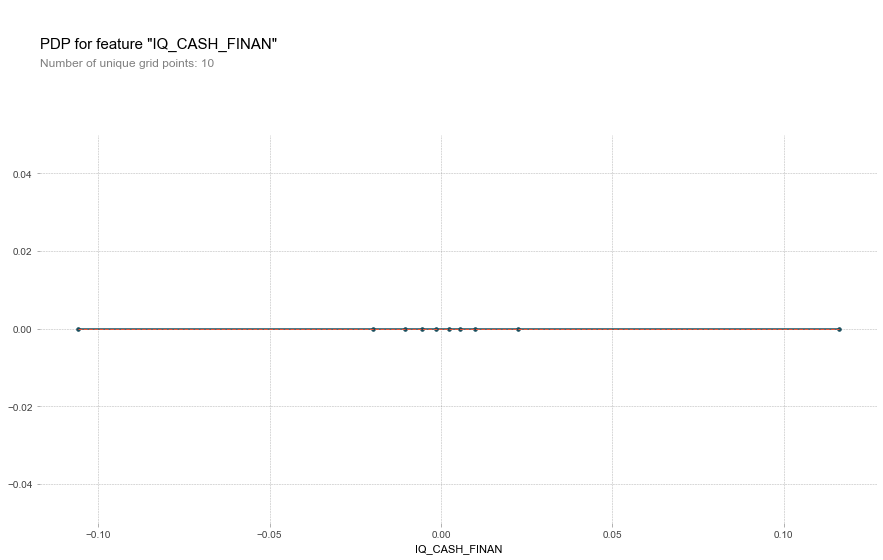

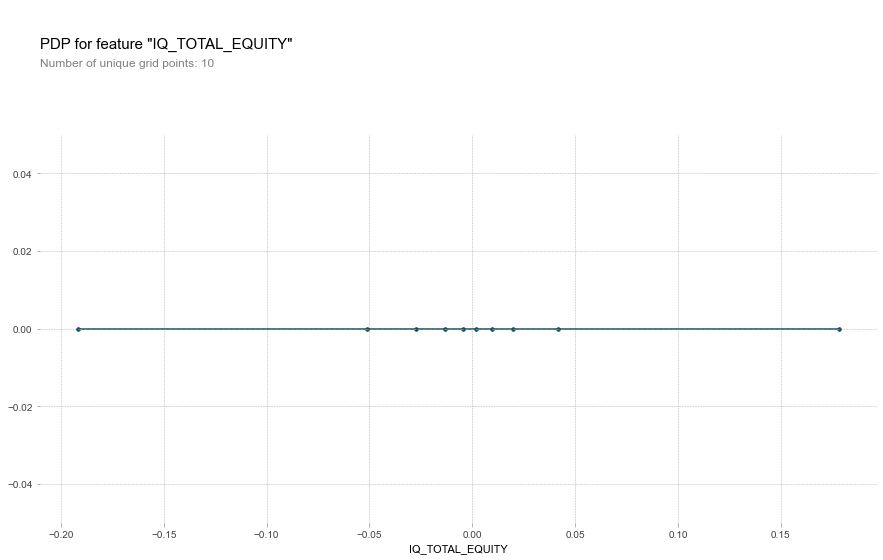

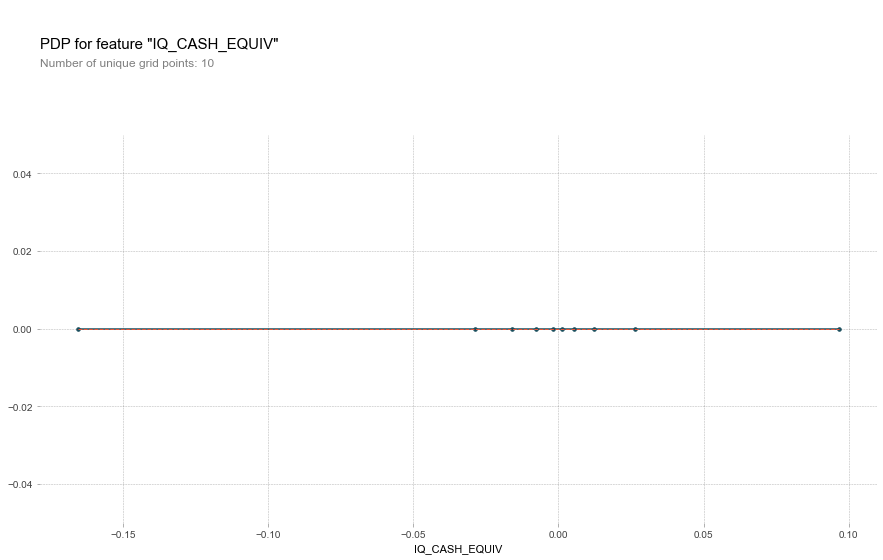

In [17]:
## PDP Plots 
def PDP_Plot_Graphs(test_x, cols): 
    '''Create PDP Plots'''
    
    pdp_plot = [] 
    for i in cols[1:]: 
        '''Create Graph for pdp plots'''
        
        pdp_rating = pdp.pdp_isolate(model = model, 
                            dataset = test_x, 
                            model_features = cols[1:], 
                            feature = i) 
        
        pdp_plot.append(
        pdp.pdp_plot(pdp_rating, i) 
        )
    return pdp_plot 

pdp_plots = PDP_Plot_Graphs(test_x, cols) 

Text(0.5, 0, 'IQ_TOTAL_ASSETS')

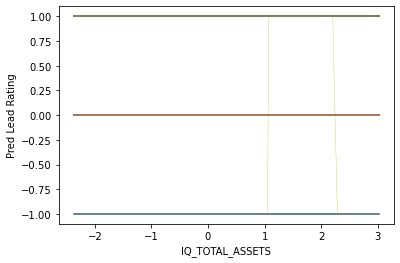

In [8]:
ice_returns = ice(data = test_x, column = cols[2], 
                 predict = model.predict)
ice_plot(ice_returns, linewidth = 0.3) 
plt.ylabel('Pred Lead Rating') 
plt.xlabel(cols[2])

# ICE

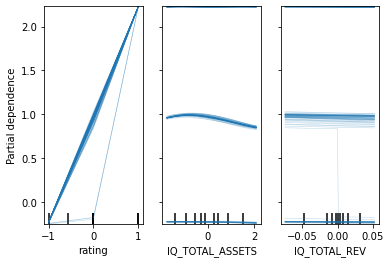

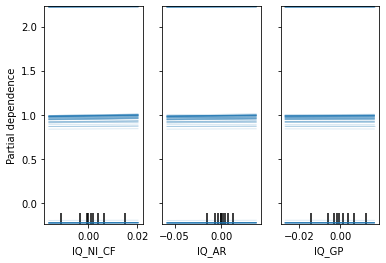

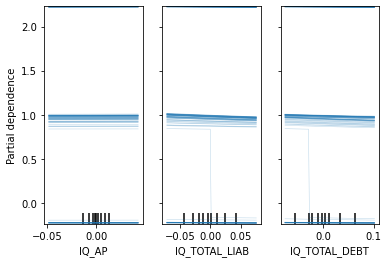

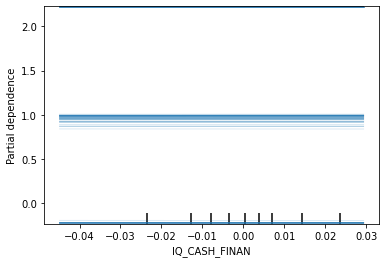

In [10]:

plot_partial_dependence(model, train_x.sample(100,random_state=1), [0,1,2],target=1,kind='individual') 
plot_partial_dependence(model, train_x.sample(100,random_state=1), [3,4,5],target=1,kind='individual')
plot_partial_dependence(model, train_x.sample(100,random_state=1), [6,7,8],target=1,kind='individual')
plot_partial_dependence(model, train_x.sample(100,random_state=1), [9],target=1,kind='individual')

# PDP

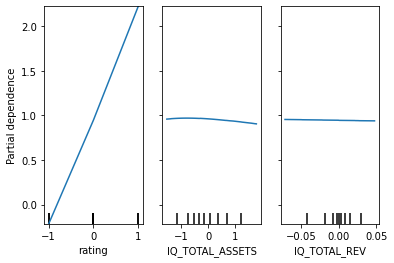

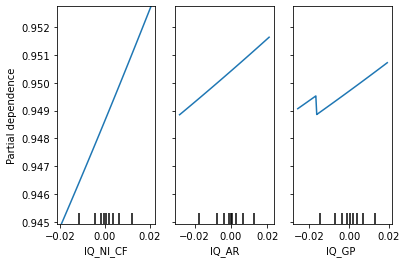

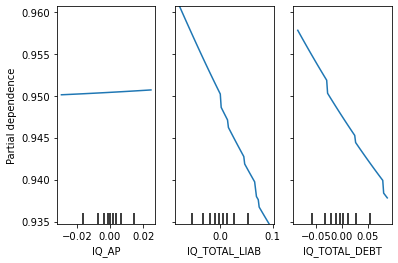

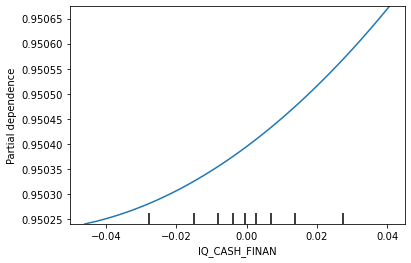

In [11]:
plot_partial_dependence(model, train_x, [0,1,2],target=1) 
plot_partial_dependence(model, train_x, [3,4,5],target=1) 
plot_partial_dependence(model, train_x, [6,7,8],target=1) 
plot_partial_dependence(model, train_x, [9],target=1) 

# ALE

In [12]:
from alepython import ale_plot
# Plots ALE of feature 'cont' with Monte-Carlo replicas (default : 50).
for i in train_x.columns.values:
    ale_plot(model, train_x, i, monte_carlo=True)

ModuleNotFoundError: No module named 'alepython'

# Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model, train_x, train_y, n_repeats=10, random_state=0)
import matplotlib.pyplot as plt

importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, train_x.columns.values[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plot = plt.xticks(range(train_x.shape[1]), train_x.columns.values[indices])
plt.xlim([-1, train_x.shape[1]])
plt.setp(plt.gca().get_xticklabels(), rotation=40, horizontalalignment='right')
plt.savefig("Test.png")
plt.show()

In [81]:
list(test_y.unique())

[1.0, -0.0, -1.0]

## Lime Plot 

In [93]:
import lime 
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    np.array(train_x), 
    feature_names = train_x.columns, 
    class_names = list(test_y.unique()),
    mode = 'classification'
)

exp = explainer.explain_instance(test_x.iloc[2], 
                                model.predict_proba)

exp.show_in_notebook(show_table = True) 

In [92]:
test_x.head()

rating  IQ_TOTAL_ASSETS  IQ_TOTAL_REV  IQ_NI_CF     IQ_AR  \
year ID                                                                
2011 MA       1.0         0.077923      0.002562 -0.007897  0.004476   
     ROST     1.0         0.770560     -0.008466  0.005406 -0.000453   
     EL      -0.0         0.464577      0.016253  0.007650  0.011998   
     CAG     -0.0        -0.001387      0.007084  0.002040  0.000400   
     XRAY     1.0         2.200276     -0.029382 -0.007056 -0.014348   

             IQ_GP      IQ_AP  IQ_TOTAL_LIAB  IQ_TOTAL_DEBT  IQ_CASH_FINAN  \
year ID                                                                      
2011 MA    0.002562  0.001622      -0.026666      -0.000838      -0.032662   
     ROST  0.006547 -0.011956      -0.021899      -0.000992      -0.006174   
     EL    0.017743 -0.000132      -0.047956      -0.040797       0.005207   
     CAG  -0.003226  0.012841       0.014077      -0.015472      -0.022303   
     XRAY -0.014044 -0.004691       0.135732       0.131077       0.068505   

           IQ_TOTAL_EQUITY  IQ_CASH_EQUIV  
year ID                                    
2011 MA           0.026666       0.033602  
     ROST         0.021899       0.049598  
     EL           0.047956      -0.033106  
     CAG         -0.014077       0.015841  
     XRAY        -0.135732      -0.064422